# FINN Preprocessor

This notebook contains the code to preprocess active fire data for the FINN fire emissions model. 

## 1. User specified configurations

To run the FINN preprocessor, you should specify the following: 

1. `tag_af`: a tag or name for your active fire dataset, e.g., `'my_af_data'`.  See below for guidance for picking `tag_af`.
2. `af_fnames`: a list of file paths to active fire shape files (e.g., downloaded from [FIRMS](https://firms.modaps.eosdis.nasa.gov/)) 
3. `year_rst`: MODIS raster data year to be used for the analysis

It is recommended to use descriptive name which identified data source (modis vs viirs), spatial extent and time period.  e.g. `modvrs_global_2018` for Modis/VIIRS combined detection for global scale modeling for year 2018, or `mod_tx_2012sum` for modis detection for Texas for Summer 2012 (definition of "summer" is implicit here).

The variable `tag_af` is used as part of PostGIS database schema and table ("[SQL Identifier](https://www.postgresql.org/docs/current/sql-syntax-lexical.html#SQL-SYNTAX-IDENTIFIERS)"), and you have to start with letter (a-z, A-Z) or underscore (\_) followed by letter/underscore/digit (0-9).

Final output files will be named "out_<i>tag_af</i>_*.csv" and "out_<i>tag_af</i>_*.shp".


### Default settings

To use a small example dataset that is bundled with the FINN preprocessor, you can use the following settings:

```python
tag_af = 'testOTS_092018'

af_fnames = [
    '../sample_datasets/fire/testOTS_092018/fire_archive_M6_23960.shp',
    '../sample_datasets/fire/testOTS_092018/fire_archive_V1_23961.shp',
]

year_rst = 2017
```

### Custom settings with MODIS and VIIRS

**If you have custom MODIS and VIIRS shapefiles** you must specify the file path(s) to the active fire data shapefiles. Ensure that the shapefiles are unzipped and placed within the `finn_preproc/data/` directory:

```python
tag_af = 'custom_job1'

af_fname = [
    '../data/fire_archive_M6_...',
    '../data/fire_archive_V1_...'
]

year_rst = 2017
```

### Custom settings with MODIS or VIIRS

Alternatively, if you have just MODIS or VIIRS, you can specify one file path, e.g.:

```python
tag_af = 'custom_job2'

af_fname = [
    '../data/fire_archive_M6_...',
]

year_rst = 2017
```

In [1]:
tag_af = 'testLouisiana2012_keptpersistent'

af_fnames = [
    '../data/fire/louisiana_2012/fire_archive_M6_48312.shp',
    '../data/fire/louisiana_2012/fire_archive_V1_48313.shp',
]

year_rst = 2012
filter_persistent_sources = False

The rest of code below should run without modification.

## 2. Generic preparation of the preprocessor

python module import

In [2]:
# python libraries
import sys
import os
import re
import glob
import datetime
import subprocess
import shlex
from urllib.parse import urlparse
from importlib import reload
import gdal
import matplotlib.pylab as plt
import psycopg2


# finn preproc codes
sys.path = sys.path + ['../code_anaconda']
import downloader
import af_import
import rst_import
import polygon_import
import run_step1
import run_step2
import export_shp
import plotter

Need PL/Python3

In [3]:
try:
    subprocess.run(['psql', '-d', 'finn', '-c', 'CREATE LANGUAGE plpython3u;'], check=True, stderr=subprocess.PIPE)
except subprocess.CalledProcessError as e:
    if 'already exists' in e.stderr.decode():
        print(e.stderr.decode().replace('ERROR','OK').strip())

OK:  language "plpython3u" already exists


Need wireframe of modis files

In [4]:
reload(rst_import)
rst_import.prep_modis_tile()

OK: wireframe already exists


## 3. Import AF dataset

### Test active fire data files exist

This particular sample AF dataset are provided by FINN developper.  In other applications, it will be user's resoponsibility to provide shape file for active fire in specified path/name.

In [5]:
# check input file exists
print('checking if input files exist:')
re_shp = re.compile('fire_archive_(.*).shp')
re_zip = re.compile('DL_FIRE_(.*).shp')
re_shp_nrt = re.compile('(MODIS_C6|VNP14IMGTDL_NRT)_(.*).shp')


for i,af_fname in enumerate(af_fnames):
    print("%s: " % af_fname, end='')
    
    pn,fn = os.path.split(af_fname)
    zname = None
    
    if os.path.exists(af_fname):
        print("exists.")
        # if .zip file, need to expand.
        if af_fname[-4:] == '.shp':
            # you are good
            print('OK')
        
        elif af_fname[-4:] == '.zip':
            # still need to unzip
            zname = af_fname
            m = re_zip.match(af_fname)
            if m:
                arcname = m.group()[0]
                sname = 'fire_archive_%s.shp' % arcname
            else:
                # i cannot predict name of shp file...
                import zipfile
                # find what shp file included...?
                raise RuntileError('specify .shp file in af_names list!')
                arcname,sname = None, None
        else:
            raise RuntimeError('specify .shp file in af_names list!')
    else:
        print("doesn't exist.")
        
        if af_fname[-4:] == '.shp':
            # guess the zip file name
            
            pn,fn=os.path.split(af_fname)
            
            # see if it's the sample giant archive we provide 
            if fn == 'fire_archive_M6_28864.shp':
                zurl = 'https://s3-us-west-2.amazonaws.com/earthlab-finn/2016-global-DL_FIRE_M6_28864.zip'
                zn = '2016-global-DL_FIRE_M6_28864.zip'
                zname = os.path.join(pn, zn)
                sname = fn
                if not os.path.exists(zname):
                    print('downloading the sample AF file: %s' % zn)
                    subprocess.run(['wget', '-P', pn, zurl], check=True)
            else:

                # see if it's an archive of AF
                m = re_shp.match(fn)
                if m:
                    arcname = m.groups()[0]
                    zname = os.path.join( pn, 'DL_FIRE_%s.zip' % arcname)
                    sname = fn
                    print('  found zip: %s' % zname)
                else:
                    # see if it's NRT data
                    m = re_shp_nrt.match(fn)

                    if m:
                        # NRT downloads
                        zname = af_fname[:-4] + '.zip'
                        sname = fn
                        print('  found zip: %s' % zname)


                    else:
                        raise RuntimeError('cannot find file: %s' % af_fname)
        else:
            raise RuntimeError('cannot find file: %s' % af_fname)
    if zname:
        print('unzipping: %s' % zname)
        subprocess.run(['unzip', '-uo', zname, '-d', os.path.dirname(zname)],
                      check=True)
        assert os.path.exists(os.path.join(pn, sname))
        af_fnames[i] = os.path.join(pn, sname)
        print('OK: done')
        

checking if input files exist:
../data/fire/louisiana_2012/fire_archive_M6_48312.shp: exists.
OK
../data/fire/louisiana_2012/fire_archive_V1_48313.shp: exists.
OK


### Import active fire data

Go ahead and import into database.

<b>Be careful!!</b> The code has no safe guard and wipe the schema for the scheama "af_<i>tag_af</i>" and starts over.  

Let me think the design a bit more for now.

In [6]:
reload(af_import)

# TODO this is destructive need to safe guard!
# tell user schema is there, list table names and # of row of each.  Ask her to delete manually or something to proceed
af_import.main(tag_af, af_fnames)

print()
for i,fn in enumerate(af_fnames):
    print(fn)
    tblname = '"af_%s".af_in_%d' % (tag_af, i+1)
    p = subprocess.run(['psql', '-c', 'select count(*) from %s;' % tblname], stdout=subprocess.PIPE)
    print(p.stdout.decode())


['psql', '-c', 'CREATE SCHEMA "af_testLouisiana2012_keptpersistent";']

cmd:
ogr2ogr -progress -f PostgreSQL -overwrite PG:dbname='finn' -lco SPATIAL_INDEX=GIST -lco SCHEMA=af_testLouisiana2012_keptpersistent -lco GEOMETRY_NAME=geom -lco FID=gid -nln af_in_1 ../data/fire/louisiana_2012/fire_archive_M6_48312.shp

['ogr2ogr', '-progress', '-f', 'PostgreSQL', '-overwrite', "PG:dbname='finn'", '-lco', 'SPATIAL_INDEX=GIST', '-lco', 'SCHEMA=af_testLouisiana2012_keptpersistent', '-lco', 'GEOMETRY_NAME=geom', '-lco', 'FID=gid', '-nln', 'af_in_1', '../data/fire/louisiana_2012/fire_archive_M6_48312.shp']

cmd:
ogr2ogr -progress -f PostgreSQL -overwrite PG:dbname='finn' -lco SPATIAL_INDEX=GIST -lco SCHEMA=af_testLouisiana2012_keptpersistent -lco GEOMETRY_NAME=geom -lco FID=gid -nln af_in_2 ../data/fire/louisiana_2012/fire_archive_V1_48313.shp

['ogr2ogr', '-progress', '-f', 'PostgreSQL', '-overwrite', "PG:dbname='finn'", '-lco', 'SPATIAL_INDEX=GIST', '-lco', 'SCHEMA=af_testLouisiana2012_keptpersi

## 4. Download raster datasets

### Settings for Land Surface Datasets (land cover, vegetation continuous field, region definieons)

In [7]:
# tag to identify datasets, automatically set to be modlct_YYYY, modvcf_YYYY
tag_lct = 'modlct_%d' % year_rst
tag_vcf = 'modvcf_%d' % year_rst

# tag for the region number polygon
tag_regnum = 'regnum'

# definition of variables in the raster files
rasters = [
        {
            'tag': tag_lct,
            'kind': 'thematic',
            'variable': 'lct'
        },
        {
            'tag': tag_vcf,
            'kind': 'continuous',
            'variables': ['tree', 'herb', 'bare'],
        },
        {
            'tag': tag_regnum,
            'kind': 'polygons',
            'variable_in': 'region_num',
            'variable': 'regnum',
        },
]

Check if the extent of raster dataset in the database encloses all fire

In [8]:
reload(downloader)
results_indb = downloader.find_tiles_indb(data='"af_%s"' % tag_af, knd='schema', tag_lct=tag_lct, tag_vcf=tag_vcf)
print(results_indb)
print()


if results_indb['n_need'] == 0:
    print('All fire are is conained in raster')
    print('no need to download/import raster dataset')
    need_to_import_lct = False
    need_to_import_vcf = False
else:
    print('Some fire are not conained in raster')
    print('Will download/import raster dataset')
    need_to_import_lct = (len(results_indb['tiles_missing_lct']) > 0)
    need_to_import_vcf = (len(results_indb['tiles_missing_vcf']) > 0)
    tiles_required_lct = results_indb['tiles_required_lct']
    tiles_required_vcf = results_indb['tiles_required_vcf']

print()
reload(downloader)
need_to_import_regnum = not downloader.find_table_indb('raster', 'rst_%s' % tag_regnum)
if need_to_import_regnum:
    print('Region definiton shapefile will be imported')
else:
    print('no need to import Region definiton shapefile')




{'n_tot': 17793, 'n_ok': 17793, 'n_need': 0, 'tiles_missing_lct': [], 'tiles_missing_vcf': [], 'tiles_required_lct': ['h09v06', 'h10v06', 'h10v05', 'h09v05'], 'tiles_required_vcf': ['h09v06', 'h10v06', 'h10v05', 'h09v05']}

All fire are is conained in raster
no need to download/import raster dataset

no need to import Region definiton shapefile


In [9]:
# Date range of active fire
# TODO use this to set "year_rst" ?
reload(af_import)
af_dates = af_import.get_dates(schema = '"af_%s"'%tag_af, combined=True)
print('first day in AF file:', af_dates.min())
print('last day in AF file:', af_dates.max())

first day in AF file: 2011-12-31
last day in AF file: 2012-12-31


Raster files URL and directories to save data

In [10]:
# all raster downloads are stored in following dir
download_rootdir = '../downloads'

In [11]:
# earthdata's URL for landcover and VCF
is_leap = (year_rst % 4 == 0)
url_lct = 'https://e4ftl01.cr.usgs.gov/MOTA/MCD12Q1.006/%d.01.01/' % year_rst
url_vcf = 'https://e4ftl01.cr.usgs.gov/MOLT/MOD44B.006/%d.03.%02d/' % (year_rst, 5 if is_leap else 6)

ddir_lct = download_rootdir +'/'+ ''.join(urlparse(url_lct)[1:3])
ddir_vcf = download_rootdir +'/'+ ''.join(urlparse(url_vcf)[1:3])

if any((need_to_import_lct, need_to_import_vcf)):
    print('LCT downloads goes to %s' % ddir_lct)
    print('VCF downloads goes to %s' % ddir_vcf)

Download land cover type raster

In [12]:
if need_to_import_lct:
    reload(downloader)
    downloader.download_only_needed(url = url_lct, droot = download_rootdir, tiles=tiles_required_lct)

Verify LCT files' checksum.  If a file is correpted, the file is downloaded again.

In [13]:
if need_to_import_lct:
    downloader.purge_corrupted(ddir = ddir_lct, url=url_lct)

Do similar for vegetation continuous field data

In [14]:
if need_to_import_vcf:
    downloader.download_only_needed(url = url_vcf, droot = download_rootdir, tiles=tiles_required_vcf)

In [15]:
if need_to_import_vcf:
    downloader.purge_corrupted(ddir_vcf, url=url_vcf)

## 5. Import raster datasets

Downloaded files need preprocessing, which is to extract the only raster band needed, and also make coordinate system to be WGS84.  Intermediate files are created in following directories.

In [16]:
workdir_lct = '../proc_rst_%s' % tag_lct
workdir_vcf = '../proc_rst_%s' % tag_vcf
workdir_regnum = '../proc_rst_%s' % tag_regnum

if need_to_import_lct:
    print('LCT preprocessing occurs in %s' % workdir_lct)
if need_to_import_vcf:
    print('VCF preprocessing occurs in %s' % workdir_vcf)
if need_to_import_regnum:
    print('RegNum preprocessing occurs in %s' % workdir_regnum)

### Import land cover type

First grab hdf file names from the download directory

In [17]:
if need_to_import_lct:
    search_string = "%(ddir_lct)s/MCD12Q1.A%(year_rst)s001.h??v??.006.*.hdf" % dict(
        ddir_lct = ddir_lct, year_rst=year_rst)
    fnames_lct = sorted(glob.glob(search_string))
    print('found %d hdf files' % len(fnames_lct) )
    if len(fnames_lct) == 0:
        raise RuntimeError("check if downloads are successful and search string to be correct: %s" % search_string)

The next command performs three tasks, "merge", "resample" and "import".  First two task creates intermediate GeoTiff files in <i>work_dir</i>.  Last task actually import the data into database's <i>raster</i> schema.

In [18]:
if need_to_import_lct:
    reload(rst_import)
    rst_import.main(tag_lct, fnames=fnames_lct, workdir = workdir_lct)

At this point you should able to see the raster in the database using QGIS.  
I am also trying to make quick check here creating simple image for QA, but use of GIS tool is encouraged.

Driver : GeoTIFF
Files : ['/vsimem/from_postgis']
Size : (2812, 1500)
Coordinate System : GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Origin : (-180.0, 70.0)
Pixel Size : (0.0533333344, -0.0533333344)
Metadata : {'AREA_OR_POINT': 'Area'}
OrderedDict([('No Data Value', 255.0), ('Min', None), ('Max', None), ('Scale', 1.0), ('Unit Type', '')])
(1500, 2812)


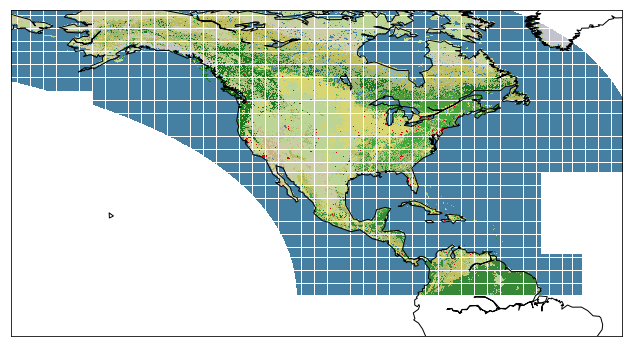

In [19]:
%matplotlib inline
import plotter
reload(plotter)
try:
    plotter.plot('raster.o_32_rst_%s' % tag_lct, '../code_anaconda/modlct.clr')
except Exception as e:
    try: 
        plotter.plot('raster.o_256_rst_%s' % tag_lct, '../code_anaconda/modlct.clr')
    
    except Exception as e2:
        print("Got this error: " + str(e))
        print("Didn't work, use QGIS!")
        pass

### Import vegetation continuous fields

Analogous steps repeated for vegetation continous fields.

In [20]:
if need_to_import_vcf:
    # grab hdf file names
    search_string = "%(ddir_vcf)s/MOD44B.A%(year)s065.h??v??.006.*.hdf" % dict(
            ddir_vcf = ddir_vcf, year=year_rst)
    fnames_vcf = sorted(glob.glob(search_string))
    print('found %d hdf files' % len(fnames_vcf) )
    if len(fnames_vcf) == 0:
        raise RuntimeError("check if downloads are successfull and search string to be correct: %s" % search_string)

In [21]:
if need_to_import_vcf:
    reload(rst_import)
    rst_import.main(tag_vcf, fnames=fnames_vcf, workdir = workdir_vcf)

Driver : GeoTIFF
Files : ['/vsimem/from_postgis']
Size : (2812, 1500)
Coordinate System : GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
Origin : (-180.0, 70.0)
Pixel Size : (0.0533333344, -0.0533333344)
Metadata : {'AREA_OR_POINT': 'Area'}
OrderedDict([('No Data Value', 255.0), ('Min', None), ('Max', None), ('Scale', 1.0), ('Unit Type', '')])
OrderedDict([('No Data Value', 255.0), ('Min', None), ('Max', None), ('Scale', 1.0), ('Unit Type', '')])
OrderedDict([('No Data Value', 255.0), ('Min', None), ('Max', None), ('Scale', 1.0), ('Unit Type', '')])
(1500, 2812, 3)


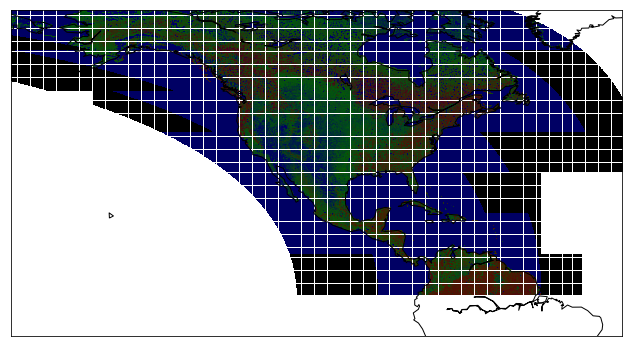

In [22]:
%matplotlib inline
import plotter
reload(plotter)
try:
    plotter.plot('raster.o_32_rst_%s' % tag_vcf)
except Exception as e:
    try:
        plotter.plot('raster.o_256_rst_%s' % tag_vcf)
    except Exception as e2:
        print("Got this error: " + str(e))
        print("Didn't work, use QGIS!")
        pass

### Import countries of the world shapefile

This is actually not a raster but vector data of polygons.  But since it serves conceptually similar function as raster (specify attribute for a given geographic location), I treat it as if it is a raster dataset.  

In [23]:
if need_to_import_regnum:
    if not os.path.exists(os.path.join(workdir_regnum, 'All_Countries.shp')):
        subprocess.run(['wget', '-P', workdir_regnum,
                        'https://s3-us-west-2.amazonaws.com/earthlab-finn/All_Countries.zip'], 
                       check=True)
        subprocess.run(['unzip', os.path.join(workdir_regnum, 'All_Countries.zip'), '-d' , workdir_regnum ], 
                       check=True)

In [24]:
if need_to_import_regnum:
    reload(polygon_import)
    polygon_import.main('regnum', shpname = os.path.join(workdir_regnum, 'All_Countries.shp'))

## 6. Process active fire data

### Running "step 1" grouping points

In [25]:
reload(run_step1)
run_step1.main(tag_af, filter_persistent_sources = filter_persistent_sources)

starting prep: 2019-04-12 18:48:01.008171
['psql', '-f', '../code_anaconda/step1_prep_v7m.sql', '-v', 'tag=testLouisiana2012_keptpersistent', '-v', 'filter_persistent_sources=False']
(datetime.date(2011, 12, 31), datetime.date(2012, 12, 31))
0
starting work 2011-12-31: 2019-04-12 18:48:01.576663
starting work 2012-01-01: 2019-04-12 18:48:02.412761
starting work 2012-01-02: 2019-04-12 18:48:03.277701
starting work 2012-01-03: 2019-04-12 18:48:04.116791
starting work 2012-01-04: 2019-04-12 18:48:04.983668
starting work 2012-01-05: 2019-04-12 18:48:06.018452
starting work 2012-01-06: 2019-04-12 18:48:06.941913
starting work 2012-01-07: 2019-04-12 18:48:07.189063
starting work 2012-01-08: 2019-04-12 18:48:08.091247
starting work 2012-01-09: 2019-04-12 18:48:08.354789
starting work 2012-01-10: 2019-04-12 18:48:08.615831
starting work 2012-01-11: 2019-04-12 18:48:08.868606
starting work 2012-01-12: 2019-04-12 18:48:09.741672
starting work 2012-01-13: 2019-04-12 18:48:10.587057
starting work 

starting work 2012-05-29: 2019-04-12 18:50:04.115425
starting work 2012-05-30: 2019-04-12 18:50:04.938311
starting work 2012-05-31: 2019-04-12 18:50:05.830621
starting work 2012-06-01: 2019-04-12 18:50:06.678618
starting work 2012-06-02: 2019-04-12 18:50:07.626321
starting work 2012-06-03: 2019-04-12 18:50:08.595416
starting work 2012-06-04: 2019-04-12 18:50:09.436770
starting work 2012-06-05: 2019-04-12 18:50:10.330916
starting work 2012-06-06: 2019-04-12 18:50:11.232179
starting work 2012-06-07: 2019-04-12 18:50:12.127749
starting work 2012-06-08: 2019-04-12 18:50:13.006131
starting work 2012-06-09: 2019-04-12 18:50:13.862766
starting work 2012-06-10: 2019-04-12 18:50:14.759870
starting work 2012-06-11: 2019-04-12 18:50:15.018265
starting work 2012-06-12: 2019-04-12 18:50:15.852795
starting work 2012-06-13: 2019-04-12 18:50:16.743582
starting work 2012-06-14: 2019-04-12 18:50:17.640701
starting work 2012-06-15: 2019-04-12 18:50:18.633788
starting work 2012-06-16: 2019-04-12 18:50:19.

starting work 2012-10-31: 2019-04-12 18:52:24.104616
starting work 2012-11-01: 2019-04-12 18:52:25.108657
starting work 2012-11-02: 2019-04-12 18:52:26.333368
starting work 2012-11-03: 2019-04-12 18:52:27.609506
starting work 2012-11-04: 2019-04-12 18:52:28.928468
starting work 2012-11-05: 2019-04-12 18:52:29.774241
starting work 2012-11-06: 2019-04-12 18:52:31.131398
starting work 2012-11-07: 2019-04-12 18:52:32.061303
starting work 2012-11-08: 2019-04-12 18:52:33.391182
starting work 2012-11-09: 2019-04-12 18:52:34.503040
starting work 2012-11-10: 2019-04-12 18:52:35.807169
starting work 2012-11-11: 2019-04-12 18:52:36.861446
starting work 2012-11-12: 2019-04-12 18:52:38.207708
starting work 2012-11-13: 2019-04-12 18:52:39.219213
starting work 2012-11-14: 2019-04-12 18:52:39.928676
starting work 2012-11-15: 2019-04-12 18:52:40.661423
starting work 2012-11-16: 2019-04-12 18:52:41.382214
starting work 2012-11-17: 2019-04-12 18:52:42.057066
starting work 2012-11-18: 2019-04-12 18:52:42.

### Running "step 2" intersection with raster datasets

In [26]:
reload(run_step2)
run_step2.main(tag_af, rasters)

starting prep: 2019-04-12 18:53:09.253959
(datetime.date(2011, 12, 31), datetime.date(2012, 12, 31))
0
starting work 2011-12-31: 2019-04-12 18:53:09.369117
starting work 2012-01-01: 2019-04-12 18:53:09.583510
starting work 2012-01-02: 2019-04-12 18:53:09.771791
starting work 2012-01-03: 2019-04-12 18:53:10.044095
starting work 2012-01-04: 2019-04-12 18:53:10.450986
starting work 2012-01-05: 2019-04-12 18:53:11.049908
starting work 2012-01-06: 2019-04-12 18:53:11.797205
starting work 2012-01-07: 2019-04-12 18:53:12.011882
starting work 2012-01-08: 2019-04-12 18:53:12.294349
starting work 2012-01-09: 2019-04-12 18:53:12.518809
starting work 2012-01-10: 2019-04-12 18:53:12.692064
starting work 2012-01-11: 2019-04-12 18:53:12.860143
starting work 2012-01-12: 2019-04-12 18:53:13.104352
starting work 2012-01-13: 2019-04-12 18:53:13.417570
starting work 2012-01-14: 2019-04-12 18:53:13.874954
starting work 2012-01-15: 2019-04-12 18:53:14.378772
starting work 2012-01-16: 2019-04-12 18:53:14.617

starting work 2012-06-01: 2019-04-12 18:54:08.308428
starting work 2012-06-02: 2019-04-12 18:54:08.874084
starting work 2012-06-03: 2019-04-12 18:54:09.500546
starting work 2012-06-04: 2019-04-12 18:54:09.821107
starting work 2012-06-05: 2019-04-12 18:54:10.102756
starting work 2012-06-06: 2019-04-12 18:54:10.406890
starting work 2012-06-07: 2019-04-12 18:54:10.868178
starting work 2012-06-08: 2019-04-12 18:54:11.342580
starting work 2012-06-09: 2019-04-12 18:54:11.622051
starting work 2012-06-10: 2019-04-12 18:54:11.870987
starting work 2012-06-11: 2019-04-12 18:54:12.087835
starting work 2012-06-12: 2019-04-12 18:54:12.328294
starting work 2012-06-13: 2019-04-12 18:54:12.598779
starting work 2012-06-14: 2019-04-12 18:54:13.087505
starting work 2012-06-15: 2019-04-12 18:54:13.590735
starting work 2012-06-16: 2019-04-12 18:54:13.876047
starting work 2012-06-17: 2019-04-12 18:54:14.212342
starting work 2012-06-18: 2019-04-12 18:54:14.498092
starting work 2012-06-19: 2019-04-12 18:54:14.

starting work 2012-11-03: 2019-04-12 18:55:07.433559
starting work 2012-11-04: 2019-04-12 18:55:07.924510
starting work 2012-11-05: 2019-04-12 18:55:08.266025
starting work 2012-11-06: 2019-04-12 18:55:08.782224
starting work 2012-11-07: 2019-04-12 18:55:09.283702
starting work 2012-11-08: 2019-04-12 18:55:10.045392
starting work 2012-11-09: 2019-04-12 18:55:11.077791
starting work 2012-11-10: 2019-04-12 18:55:11.747101
starting work 2012-11-11: 2019-04-12 18:55:12.186978
starting work 2012-11-12: 2019-04-12 18:55:12.468208
starting work 2012-11-13: 2019-04-12 18:55:12.684613
starting work 2012-11-14: 2019-04-12 18:55:13.080269
starting work 2012-11-15: 2019-04-12 18:55:13.954341
starting work 2012-11-16: 2019-04-12 18:55:14.964343
starting work 2012-11-17: 2019-04-12 18:55:15.456194
starting work 2012-11-18: 2019-04-12 18:55:16.021157
starting work 2012-11-19: 2019-04-12 18:55:16.441869
starting work 2012-11-20: 2019-04-12 18:55:16.953758
starting work 2012-11-21: 2019-04-12 18:55:17.

## 7. Export the output

Default output directory is this diretory (where you have this Jupyter Notebook file), and output file has long name of having tag of each datasets.

In [27]:
outdir = '.'
shpname = 'out_{0}_{1}_{2}_{3}.shp'.format(tag_af, tag_lct, tag_vcf, tag_regnum)

In [28]:
schema = 'af_' + tag_af
tblname = 'out_{0}_{1}_{2}'.format(tag_lct, tag_vcf, tag_regnum)
flds = ('v_lct', 'f_lct', 'v_tree', 'v_herb', 'v_bare', 'v_regnum')

In [29]:
reload(export_shp)
export_shp.main(outdir, schema, tblname, flds, shpname)

exporting: ./out_testLouisiana2012_keptpersistent_modlct_2012_modvcf_2012_regnum.csv ... Done
exporting: ./out_testLouisiana2012_keptpersistent_modlct_2012_modvcf_2012_regnum.shp ... Done


## 8. Disk use summary and clean up (if you wish)

You see summary of disk use and code which optionally cleans up disk use by removing intermediates.

### Point/Polygons

All intermediate datasets for vector processing are stored in the database.  See the usage of individual tables and grand total below.   

In [30]:
qry_af = """SELECT table_schema || '.' || table_name AS table_full_name,
pg_size_pretty(pg_total_relation_size('"' || table_schema || '"."' || table_name || '"')) AS size
FROM information_schema.tables
WHERE table_schema = '%(sch_af)s'   
ORDER BY pg_total_relation_size('"' || table_schema || '"."' || table_name || '"') DESC;""" % dict(
    sch_af=('af_%s' % tag_af),
)

qry_af_tot = """SELECT table_schema,
pg_size_pretty(sum(pg_total_relation_size('"' || table_schema || '"."' || table_name || '"'))) AS size
FROM information_schema.tables
WHERE table_schema = '%(sch_af)s'   
GROUP BY table_schema;""" % dict(
    sch_af=('af_%s' % tag_af),
)


print('Disk use by AF processing intermediate tables inside the database\n')
p = subprocess.run(['psql', '-d', 'finn', '-c', qry_af], stdout=subprocess.PIPE, check=True)
print(p.stdout.decode())

print('Total\n')
p = subprocess.run(['psql', '-d', 'finn', '-c', qry_af_tot], stdout=subprocess.PIPE, check=True)
print(p.stdout.decode())


Disk use by AF processing intermediate tables inside the database

                            table_full_name                             |    size    
------------------------------------------------------------------------+------------
 af_testLouisiana2012_keptpersistent.work_pnt                           | 6152 kB
 af_testLouisiana2012_keptpersistent.af_in_2                            | 2960 kB
 af_testLouisiana2012_keptpersistent.out_modlct_2012_modvcf_2012_regnum | 2656 kB
 af_testLouisiana2012_keptpersistent.out_modlct_2012_modvcf_2012        | 2576 kB
 af_testLouisiana2012_keptpersistent.out_modlct_2012                    | 2328 kB
 af_testLouisiana2012_keptpersistent.work_div                           | 2240 kB
 af_testLouisiana2012_keptpersistent.work_lrg                           | 1880 kB
 af_testLouisiana2012_keptpersistent.af_in_1                            | 864 kB
 af_testLouisiana2012_keptpersistent.tbl_modvcf_2012                    | 720 kB
 af_testLouisiana2012_kep

If all processing above is successful and you would like to reclaim the diskspace, you can (1) change value of `wipe_intermediate_vector` below to `True` and run the cell.

In [31]:
wipe_intermediate_vector = False
if wipe_intermediate_vector == True:
    print(tag_af)
    sch_af = 'af_%s' % tag_af
    print(sch_af)
    qry = 'DROP SCHEMA "%s" CASCADE;' % sch_af
    cmd = ['psql',  '-d', os.environ["PGDATABASE"], '-c', qry]
    subprocess.run(cmd, check=True)

### Raster

Intermediate data for raster dataset are located in three different places.  First the original HDF format file you downloaded from EarthData website.  Seond is GeoTiff format data prepared for importing into PostGIS dataset.  The third is raster dataset inside PostGIS dataset.  Diskspace usage of each are summarized below.

In [32]:
cmd = ['du', '-csh', ddir_lct, ddir_vcf]

p = subprocess.run(cmd, stdout=subprocess.PIPE)
print('Disk use by downloaded raster hdf files')
print(p.stdout.decode())

Disk use by downloaded raster hdf files
2.8G	../downloads/e4ftl01.cr.usgs.gov/MOTA/MCD12Q1.006/2012.01.01/
2.1G	../downloads/e4ftl01.cr.usgs.gov/MOLT/MOD44B.006/2012.03.05/
4.9G	total



In [33]:
cmd = ['du', '-csh', workdir_lct, workdir_vcf]
p = subprocess.run(cmd, stdout=subprocess.PIPE)
print('Disk use by intermediate raster processing files')
print(p.stdout.decode())

Disk use by intermediate raster processing files
87M	../proc_rst_modlct_2012
2.8G	../proc_rst_modvcf_2012
2.9G	total



In [34]:
qry_rst = """SELECT table_schema || '.' || table_name AS table_full_name,
pg_size_pretty(pg_total_relation_size('"' || table_schema || '"."' || table_name || '"')) AS size
FROM information_schema.tables
WHERE table_name ~ '^.*(%(tbl_lct)s|%(tbl_vcf)s)'   
ORDER BY pg_total_relation_size('"' || table_schema || '"."' || table_name || '"') DESC;""" % dict(
    tbl_lct=('rst_%s' % tag_lct),
    tbl_vcf=('rst_%s' % tag_vcf),
)
qry_rst_tot = """SELECT table_schema,
pg_size_pretty(sum(pg_total_relation_size('"' || table_schema || '"."' || table_name || '"'))) AS size
FROM information_schema.tables
WHERE table_name ~ '^.*(%(tbl_lct)s|%(tbl_vcf)s)'   
GROUP BY table_schema;""" % dict(
    sch_af=('af_%s' % tag_af),
    tbl_lct=('rst_%s' % tag_lct),
    tbl_vcf=('rst_%s' % tag_vcf),
)
print('Disk use by raster dataset in the database\n')
p = subprocess.run(['psql', '-d', 'finn', '-c', qry_rst], stdout=subprocess.PIPE, check=True)
print(p.stdout.decode())
print('Total for %(tag_lct)s and %(tag_vcf)s\n' % dict(tag_lct=tag_lct, tag_vcf=tag_vcf))
p = subprocess.run(['psql', '-d', 'finn', '-c', qry_rst_tot], stdout=subprocess.PIPE, check=True)
print(p.stdout.decode())

Disk use by raster dataset in the database

       table_full_name        |  size   
------------------------------+---------
 raster.rst_modvcf_2012       | 2139 MB
 raster.rst_modlct_2012       | 117 MB
 raster.o_32_rst_modvcf_2012  | 3480 kB
 raster.o_32_rst_modlct_2012  | 448 kB
 raster.skel_rst_modlct_2012  | 184 kB
 raster.skel_rst_modvcf_2012  | 184 kB
 raster.o_256_rst_modvcf_2012 | 96 kB
 raster.o_256_rst_modlct_2012 | 40 kB
(8 rows)


Total for modlct_2012 and modvcf_2012

 table_schema |  size   
--------------+---------
 raster       | 2260 MB
(1 row)




In [35]:
wipe_downloaded_hdf = False
wipe_intermediate_geotiff = False
wipe_intermediate_rst_in_db = False

if wipe_downloaded_hdf == True:
    # ditch entire download directory for the year
    tgts = [ddir_lct, ddir_vcf]
    cmd = ['rm', '-fr', ] + tgts

    subprocess.run(cmd, check=True)
    
if wipe_intermediate_geotiff == True:
    # ditch entire processing directory 
    tgts = [workdir_lct, workdir_vcf]
    cmd = ['rm', '-fr', ] + tgts
    print(cmd)
    subprocess.run(cmd, check=True)
    

if wipe_intermediate_rst_in_db == True:
    # delete each table from the schema 'raster'
    reload(rst_import)
    
    rst_import.drop_tables(tag_lct)
    rst_import.drop_tables(tag_vcf)
